Equação a ser modelada:

\begin{equation*}
  \begin{cases}
    \displaystyle \nabla \cdot k \nabla T + w_b c_b(T_a - T) + Q_m = 0 \text{ para } \Omega\\\\
    \displaystyle k \nabla T \cdot\vec{n} = 0 \text{ para } \partial \Omega_N\\\\
    \displaystyle T  = 37 \text{ para } \partial \Omega_D\\\\
    \displaystyle T(.,0) = 37
  \end{cases}
\end{equation*}

\begin{equation*}
  \text { onde } T : \Omega \times  I \rightarrow \mathbb{R^+} \text { representa o campo de temperatura do tecido } \\
  c_b : \Omega \times  I \rightarrow \mathbb{R^+} \text { representa o calor específico do sangue } \\
  k : \Omega \times  I \rightarrow \mathbb{R^+} \text { na qual a condutividade térmica é considerada isotrópica, mas não homogênea } \\
  w_b:  \Omega \times {R^+} \times  I \rightarrow \mathbb{R^+} \text { taxa de perfusão sanguínea } \\
  T_a \text { temperatura arterial } \\
  Q_m : \Omega \times  I \rightarrow \mathbb{R^+} \text { representa a geração de calor metabólico } \\
  f : \Omega \times  I \rightarrow \mathbb{R^+} \text { temperaturaprescrita(Dirichelet) ou fluxo (Neumann ou Robin} \\
  \alpha , \beta : \Omega \times  I \rightarrow \mathbb{R^+} \text { sendo o vetor normal unitário } \\
\end{equation*}

Considerando o caso mais geral de equação linear de segunda ordem, temos:

\begin{equation}
  a(x)u''(x) + b(x)u'(x) + c(x)u(x) = f(x)
\end{equation}

juntamente com 2 condições de contorno, uma de Dirichlet e outra de Neumman:
$u(a)= 37 $-> Dirichelet e $ u(b) = 0$ -> Neumman

Assim transferindo e adapatando para a equação de Pennes simplificada divimos a equação da seguinte forma:

\begin{equation}
   ku''(x) -w_bc_bu(x) = -Q_m - w_bc_bT_a
\end{equation}

Temos que no caso geral a matriz A é montada da seguinte maneira:

\begin{equation*}
  A =
  \begin{bmatrix}
    (h^2c_1 -2a_1) & (a_1 +hb_1/2) &  &  &  &\\
    (a_2 -hb_2/2) & (h^2c_2 -2a_2) & (a_2 +hb_2/2) &  &  & \\
    &  (a_3 -hb_3/2) &  (h^2c_3 -2a_3) & (a_3 +hb_3/2) &  & \\
    &  &  ... & ... & ... &\\
    &  &  &  (a_{m-1} -hb_{m-1}/2) & (h^2c_{m-1} -2a_{m-1}) & (a_{m-1} +hb_{m-1}/2)\\
    &  &  &  &  (a_m -hb_2/2) & (h^2c_m -2a_m)\\
  \end{bmatrix}
\end{equation*}

Já a matriz F no caso geral é montada seguindo o seguinte padrão:

A matriz F vai seguir o seguinte formato:

\begin{equation*}
  f =
  \begin{bmatrix}
   f(x_1) -(a_1/h^2 -b_1/2h) \alpha \\
   f(x_2) \\
   ...  \\
   f(x_{m-1})     \\
   f(x_{m}) -(a_m/h^2 +b_m/2h) \beta \\
  \end{bmatrix}
\end{equation*}

Tomando $h = 0.25$, montamos a matriz A do sistema $Au=F$, da seguinte forma:

\begin{equation*}
  A = \frac{1}{h^2}
  \begin{bmatrix}
   -w_bc_bh^2 -2k & k &  &  &  & &\\
    k & -w_bc_bh^2 -2k & k &  &  & & \\
    &  k & -w_bc_bh^2 -2k & k &  & & \\
    &   & ... & ... & ... & & \\
    &  &  & ... & ... & ... & \\
    &  &  &  & k & -w_bc_bh^2 -2k & k\\
    &  &  &  &  & k & -w_bc_bh^2 -2k\\
  \end{bmatrix}
\end{equation*}



A matriz F vai seguir o seguinte formato:

\begin{equation*}
  f =
  \begin{bmatrix}
   f(x_1) -(k/h^2) \alpha \\
   f(x_2) \\
   ...  \\
   f(x_{99})     \\
   f(x_{100}) -(k/h^2) \beta \\
  \end{bmatrix}
\end{equation*}

Nesse sentido vamos seguir o seguinte algoritmo para resolução do problema:


1.   Montar a matriz A e F
2.   Realizar a decomposição de A, originando as matrizes L e U
2.   Resolver esse sistema aplicando a substituição e a retrosubstituição
3.   Aplicar condição de contorno em u

Para isso aplicamos o método de decomposição PLU

In [27]:
%%writefile dominio.h
#ifndef DOMINIO_H
#define DOMINIO_H

void setWb(float *wb);
void setQm(float *qm);
void setDominio(int *dom, int n);

#endif //DOMINIO_H

Overwriting dominio.h


In [28]:
%%writefile dominio.cpp
#include <iostream>
using namespace std;
#include <fstream>
#include <vector>
#include "dominio.h"

void setWb(float *wb) {
  wb[0] = 5*0.0001;
  wb[1] = 1.25*0.001;
}

void setQm(float *qm) {
  qm[0] = 420.0;
  qm[1] = 4200.0;
}

void setDominio(int *dom, int n) {
  for(int i=0; i<n; i++) {
    dom[i] = i>=37 && i<=63 ? 1 : 0;
  }
}

Overwriting dominio.cpp


In [29]:
%%writefile lu.h
#ifndef LU_H
#define LU_H

int detInd(int i, int j, int n);
void montaA(float *A, int n, float h, float *wb, float cb, float k, int *dom);
void montaF(float *F, int n, float h, int ua, int ub, float *qm, float *wb, float cb, float Ta, float k, int *dom);
void salvaMatriz1D(float *matriz, int n, const string& arquivoName);

#endif //LU_H

Overwriting lu.h


In [30]:
%%writefile lu.cpp
#include <iostream>
using namespace std;
#include <fstream>
#include <vector>
#include <string>

#include "pivoteamento.h"

void salvaMatriz1D(float *mat, int n, string arquivoName) {
    // Matriz que vai receber os valores dos tecidos
    vector<float> matriz;

    // Inicializar a matriz que vai ser salva com elementos
    matriz.resize(n);
    for (int i = 0; i < n; i++) {
      matriz[i] =  mat[i];
    }

    // Salvar a matriz de tecidos em um arquivo para ser importada posteriormente
    ofstream arquivo(arquivoName);
    if (arquivo.is_open()) {
      for (const auto& linha : matriz) {
        arquivo << linha << " ";
      }
      arquivo.close();
      cout << endl;
      cout << "C++: Matriz solucao salva em " << arquivoName << endl;
    } else {
      cerr << "C++: Erro ao abrir o arquivo" << endl;
    }
}

int detInd(int i, int j, int n) {
  return (i < 100 && j < 100) ? i*n + j : -1;
}

void montaA(float *A, int n, float h, float *wb, float cb, float k, int *dom) {

  for(int i=0; i<n; i++) {
    for(int j=0; j<n; j++) {

      if(j>=i-1 && j<i+2) {
          int tecido = dom[i]; //busca o tecido em questao para definir as variaveis

          A[detInd(i,j,n)] = i==j ?  -wb[tecido]*cb*1000*h*h -2*k : k;
      }
      else A[detInd(i,j,n)] = 0;
    }
  }

  cout << "Matriz A montada: " << endl;
  for(int i=0; i<n; i++) {
    for(int j=0; j<n; j++) {
      cout << A[detInd(i,j,n)] << " ";
    }
    cout << endl;
  }

  salvaMatriz2D(A,n,"matA.txt");
}

void montaF(float *F, int n, float h, int ua, int ub, float *qm, float *wb, float cb, float Ta, float k, int *dom) {

  for(int i=1; i<n; i++) {
    int tecido = dom[i]; //busca o tecido em questao para definir as variaveis

    F[i] = (h*h)*(-qm[tecido] -wb[tecido]*1000*cb*Ta);
  }

  F[0] = (h*h)*(-qm[dom[0]] -wb[dom[0]]*cb*1000*Ta - (k/(h*h))*ua);
  F[n-1] = (h*h)*(-qm[dom[n-1]] -wb[dom[n-1]]*cb*1000*Ta - (k/(h*h))*ub);

  cout << endl;
  cout << "Matriz F montada: " << endl;
  for(int i=0; i<n; i++) {
    cout << F[i] << " ";
  }

  salvaMatriz1D(F,n,"montaF.txt");
}

Overwriting lu.cpp


In [31]:
%%writefile pivoteamento.h
#ifndef PIVOTEAMENTO_H
#define PIVOTEAMENTO_H

void substituicaoSucess(float *A, float *F, int *p, int n, float *x);
void substituicaoRetroa(float *A, float *F, float *x, int *p, int n);
void montaPLU(float *A, float *F, float *u, int n, int *p);
void salvaMatriz2D(float *matriz, int n,  const string& arquivo);
void salvaMatriz(float *matriz, int n, const string& arquivoName);

#endif //PIVOTEAMENTO_H

Overwriting pivoteamento.h


In [32]:
%%writefile pivoteamento.cpp
#include <iostream>
using namespace std;
#include <fstream>
#include <vector>
#include <math.h>
#include <string>

#include "lu.h"

void salvaMatriz(float *mat, int n, string arquivoName) {
    // Matriz que vai receber os valores dos tecidos
    vector<float> matriz;

    // Inicializar a matriz que vai ser salva com elementos
    matriz.resize(n);
    for (int i = 0; i < n; i++) {
      matriz[i] =  mat[i];
    }

    // Salvar a matriz de tecidos em um arquivo para ser importada posteriormente
    ofstream arquivo(arquivoName);
    if (arquivo.is_open()) {
      for (const auto& linha : matriz) {
        arquivo << linha << " ";
      }
      arquivo.close();
      cout << endl;
      cout << "C++: Matriz solucao salva em " << arquivoName << endl;
    } else {
      cerr << "C++: Erro ao abrir o arquivo" << endl;
    }
}

void salvaMatriz2D(float *mat, int n,  const string& arquivo) {
    ofstream arquivoSaida(arquivo);
    if (arquivoSaida.is_open()) {
        for (int i = 0; i < n; i++) {
            for (int j = 0; j < n; j++) {
                arquivoSaida << mat[i * n + j] << " ";
            }
            arquivoSaida << endl;  // Pular para a próxima linha no arquivo
        }
        arquivoSaida.close();
        cout << "Matriz solução salva em " << arquivo << endl;
    } else {
        cerr << "Erro ao abrir o arquivo" << endl;
    }
}

//SUBSTITUICAO SUCESSIVA Lx = pF
void substituicaoSucess(float *A, float *F, int *p, int n, float *x) {
  for(int k=0; k<n; k++) {
    x[k] = F[p[k]];

    for(int j=0; j<k; j++) {
      x[k] = x[k] - A[detInd(p[k],j,n)]*x[j];
    }
    x[k] = x[k]/1.0; //pode retirar
  }

  cout << endl;
  cout << endl;
  cout << endl;
  cout << "Matriz y: " << endl;
  for(int i=0; i<n; i++) {
    cout << x[i] << " ";
  }
}

//SUBSTITUICAO RETROATIVA Ux = F
void substituicaoRetroa(float *A, float *F, float *x, int *p, int n) {
  for(int k=n; k>=0; k--) {

    for(int j=k+1; j<n; j++) {
      x[k] = x[k] -A[detInd(p[k],j,n)]*x[j];
    }
    x[k] = x[k]/A[detInd(p[k],k,n)];

  }

  cout << endl;
  cout << endl;
  cout << endl;
  cout << "Matriz solucao: " << endl;
  for(int i=0; i<n; i++) {
    cout << x[i] << " ";
  }



  salvaMatriz(x,n+2,"matriz.txt");
}


void montaPLU(float *A, float *F, float *u, int n, int *p) {
  for(int k=0; k<n; k++) {
    //ENCONTRAR PIVOS DE A
    float max = fabs(A[detInd(p[k],k,n)]);
    int iMax = k;

    for(int i=k+1; i<n; i++) {
      if(max<fabs(A[detInd(p[i],k,n)])) {
        max = fabs(A[detInd(p[i],k,n)]);
        iMax = i;
      }
      //cout << endl;
      //cout << endl;
      //cout << endl;
      //cout << "Maior pivo: " << max << endl;
    }
    //cout << "Indice: " << iMax << endl;

    int tmp = p[k];
    p[k] = p[iMax];
    p[iMax] = tmp;

    //anular elementos
    for(int i=k+1; i<n; i++) {
      float m = A[detInd(p[i],k,n)]/A[detInd(p[k],k,n)];
      //F[i] = F[p[k]] - F[p[i]];
      A[detInd(p[i],k,n)] = m;
      for(int j=k+1; j<n; j++) {
        A[detInd(p[i],j,n)] = A[detInd(p[i],j,n)] - (m*A[detInd(p[k],j,n)]);
      }

    }
  }

  cout << endl;
  cout << endl;
  cout << endl;
  cout << "Matriz A(LU): " << endl;
  for(int i=0; i<n; i++) {
    for(int j=0; j<n; j++) {
      cout << A[detInd(p[i],j,n)] << ", ";
    }
    cout << endl;
  }
}

Overwriting pivoteamento.cpp


In [33]:
%%writefile main.cpp
#include <iostream>
using namespace std;
#include <string>
#include <cmath>

#include "dominio.h"
#include "lu.h"
#include "pivoteamento.h"

int main()
{
    //PROPRIEDADES DA EQUACAO
    int n = 100; //tamanho do dominio
    float h = 0.001;
    int ua = 37; //condicao de contorno de dirichelet a esquerda
    int ub = 37; //condicao de contorno neumman a direita -> fluxo nulo de calor
    int *dom = new int[n];

    //PROPRIEDADE DAS VARIAVEIS DO SISTEMA
    float k = 0.5;
    float cb = 4200;
    float Ta = 37;
    float *wb = new float[4];
    float *qm = new float[4];

    setWb(wb);
    setQm(qm);
    setDominio(dom, n);

    float *A = new float[(n)*(n)]; //matriz A
    float *F = new float[(n)]; //matriz F
    float *u = new float[n]; //vetor solucao
    int *p = new int[(n)]; //vetor para pivoteamento

    for(int i=0; i<n; i++) {
      p[i] = i;
    }

    float *x = new float[n+2];

    for(int i=0; i<n; i++) {
      x[i] = 0;
    }

    montaA(A, n, h, wb, cb, k, dom); //monta a matriz A
    montaF(F, n, h, ua, ub, qm, wb, cb, Ta, k, dom); //monta a matriz F
    montaPLU(A, F, u, n, p); //decomposicao LU
    substituicaoSucess(A, F, p, n, x); //substituicao
    substituicaoRetroa(A, F, x, p, n); //retrosubstituicao com resultado


    //aplica as condicoes de contorno
    //u[0] = ua;
    //u[n+1] = ub;

    delete [] A;
    delete [] F;
    delete [] u;
    delete [] p;

    return 0;
}

Overwriting main.cpp


In [34]:
!g++ lu.cpp \
  dominio.cpp \
  pivoteamento.cpp \
  main.cpp \
  -o decompLu

In [35]:
!./decompLu

Matriz A montada: 
-1.0021 0.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0.5 -1.0021 0.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0.5 -1.0021 0.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0.5 -1.0021 0.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0.5 -1.0021 0.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

[37.0166 37.0324 37.0475 37.062  37.0758 37.0892 37.1021 37.1146 37.1267
 37.1385 37.1501 37.1614 37.1726 37.1837 37.1947 37.2057 37.2167 37.2278
 37.2389 37.2503 37.2619 37.2737 37.2858 37.2983 37.3112 37.3245 37.3384
 37.3529 37.368  37.3838 37.4004 37.4178 37.4362 37.4555 37.4759 37.4974
 37.5202 37.5444 37.5659 37.5849 37.6016 37.6163 37.629  37.6399 37.6492
 37.6568 37.663  37.6677 37.671  37.673  37.6736 37.6729 37.6709 37.6675
 37.6627 37.6565 37.6488 37.6395 37.6284 37.6156 37.6009 37.5841 37.5649
 37.5434 37.5191 37.4961 37.4744 37.4539 37.4344 37.4159 37.3983 37.3815
 37.3656 37.3502 37.3356 37.3215 37.3079 37.2947 37.282  37.2696 37.2575
 37.2456 37.2339 37.2224 37.2109 37.1995 37.1881 37.1767 37.1651 37.1534
 37.1415 37.1294 37.1169 37.1041 37.0909 37.0773 37.0631 37.0483 37.033
 37.0169     nan  0.    ]


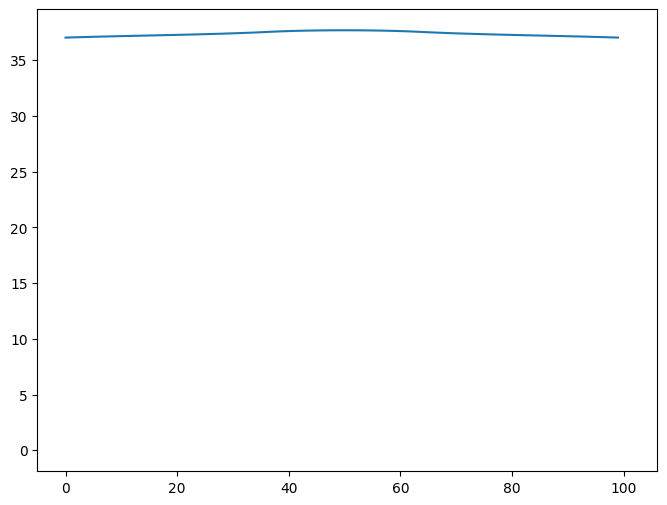

In [36]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d, Axes3D
import numpy as np
import math

from google.colab import files
from matplotlib.figure import projections

plt.rcParams['figure.figsize'] = [8, 6]

# Carregar a matriz do arquivo
resultados = np.loadtxt('matriz.txt')

# Exibir a matriz
print(resultados)

plt.plot(resultados)

Solve do phyton

In [37]:
!pip install --upgrade numpy
!pip install scipy

[37.01653364 37.03233673 37.04743563 37.06189376 37.07577185 37.08912817
 37.10201883 37.11449798 37.12661801 37.13842984 37.14998308 37.16132624
 37.17250698 37.18357224 37.19456851 37.20554196 37.2165387  37.22760489
 37.23878702 37.25013206 37.26168766 37.27350234 37.28562573 37.29810875
 37.31100383 37.32436513 37.33824875 37.35271302 37.36781869 37.3836292
 37.40021094 37.41763358 37.43597027 37.45529804 37.47569806 37.49725602
 37.52006245 37.54421314 37.56567807 37.58468261 37.60142633 37.61608502
 37.62881261 37.63974273 37.64899014 37.65665195 37.66280861 37.66752476
 37.67084992 37.672819   37.67345269 37.67275762 37.67072651 37.66733803
 37.6625566  37.65633201 37.64859891 37.6392761  37.62826568 37.61545206
 37.60070068 37.58385666 37.56474314 37.54315942 37.51887887 37.49593761
 37.47423929 37.45369278 37.43421177 37.41571446 37.39812314 37.38136395
 37.36536648 37.35006355 37.33539089 37.32128687 37.30769225 37.29454994
 37.28180474 37.26940312 37.257293   37.2454235  37.

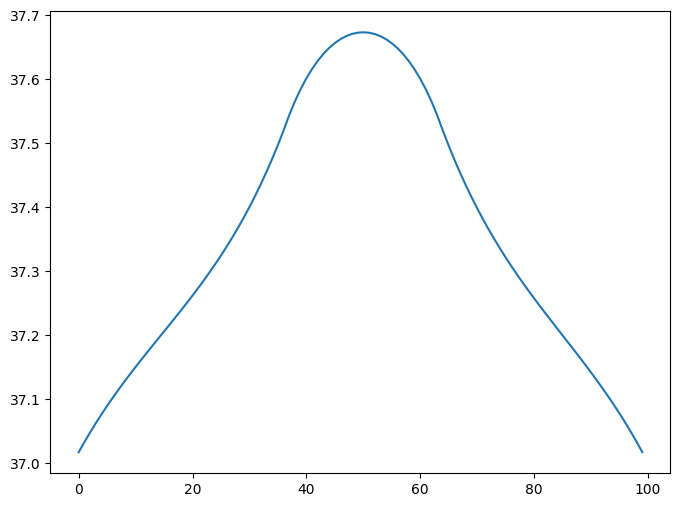

In [38]:
import numpy as np
from scipy.linalg import lu

def decomposicao_PLU(A, F) :

  P, L, U = lu(A)
  x = np.linalg.solve(L, np.dot(P, F)) #vai resolver Lx = PF(Sucessiva)
  sol = np.linalg.solve(U, x) #vai resolver Ux = F(Retroativa)

  return sol

# Carregar a matriz do arquivo
A = np.loadtxt('matA.txt')
F = np.loadtxt('montaF.txt')

sol = decomposicao_PLU(A,F)
print(sol)

plt.plot(sol)